In [1]:
    # conda install -c conda-forge cvxpy

In [2]:
'''PROBLEM SETUP'''
import gen_wind_field
import dynamics
import numpy as np
import cvxpy as cp
global n, m # get the state dimension
n, m = 6, 3 # get the control dimension

mass = 1
g = 9.81
rho = 1.225
s = 1
Cd = 0.05
x0 = np.array([100.0, 200.0, 20.0, 10, 0.0, 0.0])
x_goal = np.array([400.0, 250.0, 30.0, 1.0, 0.0, 0.0])
t_goal = 30.0
t_step = 0.25
t_array = np.arange(0.0,t_goal+t_step,t_step)
N = int(t_goal / float(t_step))

xlb = np.array([0, 0, 0, 0, - np.pi / 4.0, - np.pi / 2.0])
xub = np.array([500, 500, 50, 20, np.pi / 4.0, np.pi / 2.0])
ulb = np.array([-1, - np.pi / 4.0, 0])
uub = np.array([1, np.pi / 4.0, mass * g])
bounds = [[xlb[0], xub[0]], [xlb[1], xub[1]]]
resolution = [10, 10]
mu = [0.0, 0.0, 0.0]
sigma = [0.0, 0.0, 0.0]
thermal_list = [[200, 300]]
wind = gen_wind_field.WindField(bounds, resolution, mu, sigma, thermal_list)
dyn = dynamics.Dynamics(mass, g, rho, s, Cd, wind)


"""
Generate a nominal trajectory:
basic interpolation from initial state to final state
with back solving for the control, except for 
"""
V = np.linalg.norm(x_goal - x0) / float(t_goal)
q = 0.5 * rho * V**2
CL = m * g / (q * s) + 0.001
phi = 0
T = Cd * q * s
u_ref = np.tile([CL, phi, T], [N, 1])
x_ref = np.tile(x0, [N, 1])
for i in range(N - 1):
    x_ref[i + 1, :] = x_ref[i, :] + dyn.f(x_ref[i, :], u_ref[i, :]) * t_step

"""
Set up initial state and control parameters
state = x, y, z, V, gamma, psi
control = Cl, phi, T
"""

state = np.reshape(x_ref,((n*(N)),1))  
control = np.reshape(u_ref,((m*(N)),1))  
z_old = np.vstack([state,control])
# Define trust regions 
epsTrust = 10

# SET UP INDEXING FUNCTIONS
u_shift = n*N 
def x_start(i):
    global n
    return (i-1)*(n) 

def x_end(i):
    global n
    return i*(n) 

def u_start(i):
    global n
    return u_shift + (i-1)*(m)  

def u_end(i):
    global n
    return u_shift + i*(m) 



In [3]:
def solveLOCP(z_old):
    global n, m
    x_vec = np.reshape(z_old[0:N*n],(N,n))
    u_vec = np.reshape(z_old[N*n:z_old.size+1],(N,m))
    n_constraints = (n)*N
    C = np.zeros([n_constraints, (n+m)*N])                          
    d = np.zeros([n_constraints, 1])
    lb = np.zeros([(n+m)*N,1])
    ub = np.zeros([(n+m)*N,1])
    h = t_step

    for i in range(1, N):  # Dynamic constraints
        state_k = x_vec[i-1]  
        control_k = u_vec[i-1]  
    #         print(state_k)
        f_Dyn = dyn.f(state_k, control_k)
        DxyfDyn_k = dyn.dfdx(state_k, control_k)
        DufDyn_k = dyn.dfdu(state_k, control_k)

        C[x_start(i):x_end(i), x_start(i + 1):x_end(i + 1)] = np.eye(n)
        C[x_start(i):x_end(i), x_start(i):x_end(i)] = - (h * DxyfDyn_k) # + np.eye(n))
        C[x_start(i):x_end(i), u_start(i):u_end(i)] = - h * DufDyn_k
        d[x_start(i):x_end(i), 0] = (f_Dyn - np.dot(DxyfDyn_k, state_k) - np.dot(DufDyn_k, control_k)) * h

    C[x_start(N):x_end(N), x_start(1):x_end(1)] = np.eye(n)
    d[x_start(N):x_end(N), 0] = x0
#     C[x_start(N):x_end(N), x_start(N):x_end(N)] = np.eye(n)
#     d[x_start(N):x_end(N), 0] = x_goal
    
    lb = -1000 * np.ones([(n + m) * N, 1])
    ub = 1000 * np.ones([(n + m) * N, 1])
    z0 = np.zeros([(n + m) * N, 1])
    u_lb, u_ub = -10, 10

    lb[u_shift:u_shift + m * N] = u_lb * np.ones([m * N, 1])  # set lower bound for control
    ub[u_shift:u_shift + m * N] = u_ub * np.ones([m * N, 1])  # set upper bound for control

    # TARGET STATE FOR z
    for i in range(1, N+1):
        z0[(i - 1) * n:i * n] = np.vstack(x_goal)
    z0.reshape(z0.shape[0])

    # Cost
    M = np.zeros(((n + m) * N, (n + m) * N))
    for i in range(1, N+1):
        if (i < N):
            M[x_start(i): x_end(i), x_start(i): x_end(i)] = np.eye(n) * 100
        else:
            M[x_start(i): x_end(i), x_start(i): x_end(i)] = np.eye(n) * 1000

        M[u_start(i): u_end(i), u_start(i): u_end(i)] = np.eye(m)

    # SET CONSTRAINTS FOR TRUST REGION
    rho = 75.0
    lb_trust = z_old - rho
    ub_trust = z_old + rho

    # CONSTRUCT THE OPTIMIZATION PROBLEM
    z = cp.Variable(((n+m)*N,1))
    z.value = z_old
    zTMz = cp.quad_form((z-z0), M)
    objective = cp.Minimize(zTMz)
    constraints = [C@z==d, lb <= z, z <= ub]
    prob = cp.Problem(objective, constraints)

    # The optimal objective value is returned by `prob.solve()`.
    result = prob.solve()

    return z


In [4]:
# global n, m
# x_ref = np.reshape(z_old[0:N*n],(N,n))
# u_ref = np.reshape(z_old[N*n:z_old.size+1],(N,m))
# n_constraints = (n)*N
# C = np.zeros([n_constraints, (n+m)*N])                          
# d = np.zeros([n_constraints, 1])
# lb = np.zeros([(n + m) * N, 1])
# ub = np.zeros([(n + m) * N, 1])
# h = t_step

# for i in range(1, N):  # Dynamic constraints
#     state_k = x_ref[i-1]  
#     control_k = u_ref[i-1]  
# #         print(state_k)
#     f_Dyn = dyn.f(state_k, control_k)
#     DxyfDyn_k = dyn.dfdx(state_k, control_k)
#     DufDyn_k = dyn.dfdu(state_k, control_k)

#     C[x_start(i):x_end(i), x_start(i + 1):x_end(i + 1)] = np.eye(n)
#     C[x_start(i):x_end(i), x_start(i):x_end(i)] = - (h * DxyfDyn_k + np.eye(n))
#     C[x_start(i):x_end(i), u_start(i):u_end(i)] = - h * DufDyn_k
#     d[x_start(i):x_end(i), 0] = (f_Dyn - np.dot(DxyfDyn_k, state_k) - np.dot(DufDyn_k, control_k)) * h

# C[x_start(1):x_end(1), x_start(1):x_end(1)] = np.eye(n)
# d[x_start(1):x_end(1), 0] = x0
# C[x_start(N):x_end(N), x_start(N):x_end(N)] = np.eye(n)
# d[x_start(N):x_end(N), 0] = x_goal
# # print(d)
# # there could be a bug here, check the control doesnt overlap the state
# lb = -1000 * np.ones([(n + m) * N, 1])
# ub = 1000 * np.ones([(n + m) * N, 1])
# z0 = np.zeros([(n + m) * N, 1])
# u_lb, u_ub = -10, 10

# lb[u_shift:u_shift + m * N] = u_lb * np.ones([m * N, 1])  # set lower bound for control
# ub[u_shift:u_shift + m * N] = u_ub * np.ones([m * N, 1])  # set upper bound for control

# # TARGET STATE FOR z
# for i in range(1, N+1):
#     z0[(i - 1) * n:i * n] = np.vstack(x_goal)
# z0.reshape(z0.shape[0])

# # Cost
# M = np.zeros(((n + m) * N, (n + m) * N))
# for i in range(1, N+1):
#     if (i < N):
#         M[x_start(i): x_end(i), x_start(i): x_end(i)] = np.eye(n) * 10
#     else:
#         M[x_start(i): x_end(i), x_start(i): x_end(i)] = np.eye(n) * 100

#     M[u_start(i): u_end(i), u_start(i): u_end(i)] = np.eye(m)

# # SET CONSTRAINTS FOR TRUST REGION
# rho = 50.0
# lb_trust = z_old - rho
# ub_trust = z_old + rho


# # CONSTRUCT THE OPTIMIZATION PROBLEM
# z = cp.Variable(((n+m)*N,1))
# z.value = z_old
# zTMz = cp.quad_form((z-z0), M)
# objective = cp.Minimize(zTMz)
# constraints = [C@z==d, lb <= z, z <= ub]
# prob = cp.Problem(objective, constraints)

# # The optimal objective value is returned by `prob.solve()`.
# result = prob.solve()


In [5]:
counter = 1
epsSCP = 100
done = 0

#  first iteration

print('SCP iteration', counter)
z_new = solveLOCP(z_old)
err = np.linalg.norm(z_new.value-z_old)
z_old = z_new.value
counter = counter + 1


while done == 0:
    
    print('SCP iteration', counter)
    z_new = solveLOCP(z_old)
    
    err = np.linalg.norm(z_new.value-z_old)
    if err < epsSCP:
        done = 1
        
    z_old = z_new.value
    counter = counter + 1
    
    

SCP iteration 1
SCP iteration 2


TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'

In [6]:
x_o = np.zeros([N+1,1])
y_o = np.zeros([N+1,1])
z_o = np.zeros([N+1,1])
V_o = np.zeros([N+1,1])
gamma_o = np.zeros([N+1,1])
psi_o = np.zeros([N+1,1])
z = z_old
for i in range(1,N+1): 
    x_o[i] = z[x_start(i)]
    y_o[i] = z[x_start(i)+1] 
    z_o[i] = z[x_start(i)+2]
    V_o[i] = z[x_start(i)+3]
    gamma_o[i] = z[x_start(i)+4]
    psi_o[i]   = z[x_start(i)+5]
    
y_o = y_o[0:y_o.size-1] 
x_o = x_o[0:x_o.size-1] 
z_o = z_o[0:z_o.size-1] 


SyntaxError: invalid syntax (<ipython-input-10-1d60b72848a1>, line 1)

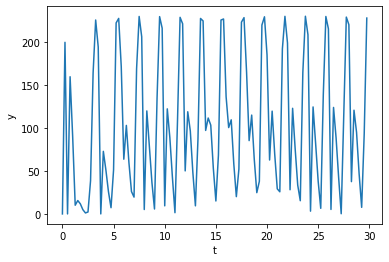

In [7]:
import matplotlib.pyplot as plt
plt.plot(t_array[0:(y_o.size)],y_o)
plt.xlabel('t'),plt.ylabel('y')
plt.show()

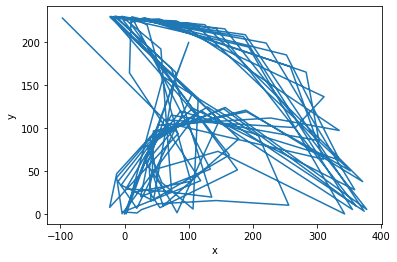

In [8]:
plt.plot(x_o,y_o)
plt.xlabel('x'),plt.ylabel('y')
plt.show()

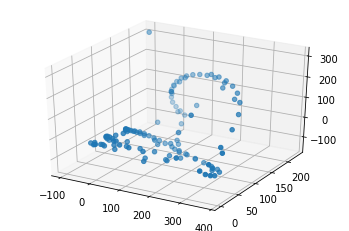

In [9]:
from mpl_toolkits import mplot3d

fig = plt.figure()
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = z_o
xline = x_o
yline = y_o
ax.scatter3D(xline, yline, zline,  cmap='Greens')

